<a href="https://colab.research.google.com/github/hyejeong1111/Deeplearning/blob/main/keras_%E1%84%80%E1%85%B5%E1%84%87%E1%85%A1%E1%86%AB_CNN%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%92%E1%85%A1%E1%84%8B%E1%85%A7_%E1%84%89%E1%85%A9%E1%86%AB%E1%84%80%E1%85%B3%E1%86%AF%E1%84%8A%E1%85%B5_%E1%84%8B%E1%85%B5%E1%84%86%E1%85%B5%E1%84%8C%E1%85%B5_%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 연구목표

- MNIST 손글씨 이미지를 데이터로 사용
- 손글씨 이미지를 넣으면 이 이미지가 숫자 몇인지를 예측하는 웹서비스(s/w)
- 예측결과
  - 이 이미지는 숫자 5입니다.
- 예측모델을 딥러닝을 활용
- 딥러닝 수행을 위해 다음 조건
  - 딥러닝 엔진은 텐서플로우 2.x 기반 케라스를 활용(High level api 활용)
  - 필요하면, 조기학습 종료를 수행
  - 필요하면, GPU를 이용한 학습 수행

In [ ]:
import tensorflow as tf

tf.__version__

'2.8.2'

In [ ]:
# 2017 tensorflow commit 행사에서 공식적으로 포함
from tensorflow import keras

keras.__version__

'2.8.0'

In [ ]:
from tensorflow.keras import backend

# 데이터획득

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# 훈련용 60000, 테스트용 10000
# (개수, 높이, 너비)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# 데이터준비/전처리

- 엔진별로 이미지 처리시 데이터 처리 포멧이 존재
  - NHWC
    - (개수:배치사이즈, 높이, 너비, 채널수)
    - 텐서플로우
  - NCHW
    - (개수:배치사이즈, 채널수, 높이, 너비)
    - 파이토치

In [ ]:
# 케라스 경우 백엔드를 통해서(실제 엔진을 접근) 포멧을 구한다
fmt = backend.image_data_format()
fmt
# channels_last => NHWC <= 텐서플로우 엔진의 기본 포멧

'channels_last'

In [ ]:
import numpy as np
np.max( X_train ), np.min( X_train ), X_train.shape
# X_train : 0 ~ 255
# 정규화가 필요해 보임 (0~255 => 0~1)

(255, 0, (60000, 28, 28))

In [ ]:
# 정답 : 0 ~ 9 => 원-핫인코딩을 활용 => 0 or 1로 표현 => 0000000001
np.unique( y_train )

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# 데이터 분석(생략)

# 모델구축(딥러닝)

- keras로 구현 (CNN), 학습, 예측

## 상수 정의

In [ ]:
# 1. 상수 정의 (환경변수)
# 이미지 관련 정보
PIXEL_H       = X_train.shape[ 1 ] # 원본 이미지의 높이 => 28
PIXEL_W       = X_train.shape[ 2 ] # 원본 이미지의 너비 => 28
PIXEL         = PIXEL_H * PIXEL_W # 원본 이미지의 총 픽셀수 => 총 feature 수 28*28 = 784
LABEL_NUM     = len( np.unique( y_train ) ) # 정답의 개수 => 10
# 이미지 채널
INPUT_CHANNEL = 1 # 원본 이미지가 grayscaled 이미지 이므로 1채널임

In [ ]:
type(X_train)

numpy.ndarray

## 데이터 준비 및 전처리

In [ ]:
# 2. 이미지 포멧에 따른 원본 데이터 shape, 차원 정리
if fmt == 'channels_last': # NHWC
  # (60000, 28, 28) => (60000, 28, 28, 1)
  # 3D -> 4D
  X_train = X_train.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
  X_test  = X_test.reshape( -1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
else: # NCHW
  # (60000, 28, 28) => (60000, 1, 28, 28)
  X_train = X_train.reshape( -1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)
  X_test  = X_test.reshape( -1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)
  pass

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# 타입 변환
X_train = X_train.astype( 'float32' )
X_test  = X_test.astype( 'float32' )

# 정규화 수행
X_train = X_train / np.max( X_train )
X_test  = X_test / np.max( X_test )

In [ ]:
np.max(X_train), np.min(X_train)

(1.0, 0.0)

In [ ]:
# 정답 데이터 원-핫 인코딩 처리 (범주형 데이터등 자연어 처리에서 많이 사용)
# 0~9 -> 0000000001 -> 0과 1로 표현을 해서 데이터가 늘어나도 그 정확도가 더 상승하는 요인
y_train = keras.utils.to_categorical(y_train, LABEL_NUM )
y_test  = keras.utils.to_categorical(y_test, LABEL_NUM )

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## 신경망 구성

- 영상 인식에 탁월한 CNN 형태로 네트워크를 구축
  - 입력층 + 은닉층(합성곱층, 풀링층,....(반복), 전결합층) + 출력층
- 엔진은 텐서플로우 기반 하이 레벨 API인 케라스로 구성



```
- 입력층
- 은닉층
  - 합성곱층 1f -> 1채널=> 32채널 확장
  - 풀링층 1f -> 이미지 크기가 28=>14로 줄어든다
  - 합성곱층 2f -> 32채널=> 64채널 확장
  - 풀링층 2f -> 이미지 크기가 14 => 7로 줄어든다
  - 전겹합층 -> 3036 -> 1024로 수렴
- 출력층 -> 1개 데이터 전체의 정보를 10개의 출력으로 수럼 -> 숫자를 예측함(확률)
```



In [ ]:
from tensorflow.keras import models, layers

In [ ]:
# 1. 모델 생성(연속적인 형태) -> 이 모델에 레이어를 추가함으로써 신경망을 구성
#.                          model.add()
model = models.Sequential()

In [ ]:
if fmt == 'channels_last': # NHWC
  # N만 빼고 표현 => layers.Conv2D()에서 그렇게 사용함 (HWC)
  input_shape = (PIXEL_H, PIXEL_W, INPUT_CHANNEL)
else:
  # CHW
  input_shape = (INPUT_CHANNEL, PIXEL_H, PIXEL_W)

In [ ]:
# 2. 각층 추가
# 2-1. 입력층의 데이터 형태를 맞춰서 첫번째 합성곱층에 바로 세팅하며서 진행
# 2-2. 합성곱층 1f : 1채널 -> 32채널 (설정) -> 이미지상의 특징 추출->특성맵, 활성화맵
model.add( layers.Conv2D(
    32,    # 합성곱층을 통과한 데이터의 출력채널수 32 => 쉬운예로 1개의 이미지가 32개로 증폭되었다
    (5,5), # (h,w) 커널의 크기, 통상 동일하게 제시
    (1,1), # (h,w) 커널의 이동량(양수), 통상 동일하게 제시
    'same',# 이미지의 경계선까지 모두 체크하도록 이미지의 바깥쪽을 확장함 <= 보정 <-> valid(유효범위)
    activation ='relu',  # 신경망을 더 깊에 구현하기 위해서 데이터를 전체적으로 조정한다=>활성화함수
                         # 데이터를 비선형으로 흐트러 놓는 역활도 담당
    input_shape=input_shape # 입력 데이터의 형태 -> 엔진따라 달라짐
) )


In [ ]:
# 2-3. 풀링층 1f -> 이미지의 특성을 강화, 최대/평균 풀링
model.add( layers.MaxPool2D(
  pool_size=(2, 2), # 커널의 크기
  strides=None,     # 커널이 이동하는 크기, None이면 pool_size와 동일
  padding='same'    # 원본과 동일 크기를 추구 -> 스트라이드가 2칸식 이동
  # 풀링층을 통과한 이미지는 절반 크기로 줄어든다(채널수는 유지) -> 28 => 14
 ) )

In [ ]:
# 2-3-1. 드롭아웃층 -> 원래 CNN의 필수 구성이 아님, 응용 -> 과적합방지층 개입 -> 기본틀에서 응용디자인
model.add( layers.Dropout(0.1) ) # 10% 정도 과적합 방지를 위해 개입(방해율 or 학습률)

In [ ]:
# 2-4. 합성곱층 2f
model.add( layers.Conv2D(
    32*2,
    (5,5),
    #(1,1), # 기본값이 (1,1)
    padding='same',
    activation='relu'
    ) )

In [ ]:
# 2-5. 풀링층 2f
model.add( layers.MaxPool2D(padding='same') )

In [ ]:
model.add( layers.Dropout(0.1) )

In [ ]:
# 2-6. 전결합층 1f -> Falttern, 차원을 펴준다 => 4D => 2D
model.add( layers.Flatten() )
# 2-6-1 출력에 수렴하기 위해서 조정 -> 특생이 없는 층 -> Dense 활용
# 7*7*64 => 1024로 수렴 : 3136 _> 1024
model.add( layers.Dense( 1024, activation='relu' ) )

In [ ]:
# 2-6-1. 드롭아웃층 -> 원래 CNN의 필수 구성이 아님, 응용 -> 과적합방지층 개입
model.add( layers.Dropout(0.1) )

In [ ]:
from threading import active_count
# 2-7. 출력층 1f : 1024=> 10개에 수렴
model.add( layers.Dense(LABEL_NUM, activation='softmax' ) )

## 컴파일 환경구성

- 손실함수, 최적화, 예측/평가 수행

In [ ]:
model.compile(
  optimizer = 'rmsprop', # 최적화 도구, adam, sgd, 모멘텀,..경사하강법등등,,,
  # 손실함수 -> 잘 훈련되었는지 판단하는 잣대(실제값, 예측값의 오차를 기준), 분류값이 10개
  loss      = keras.losses.categorical_crossentropy,
  # 평가도구
  metrics   = ['accuracy']
)

## 학습(fit or train)

- 실시간 관점
  - 온라인 학습
    - 실시간적으로 학습 -> 결과를 서비스에 반영
      - 빠르 피드백, 리스크 존재
  - 오프라인 학습
    - 모델 업데이트시 시스템 셧다운후 반영
- 학습 데이터 관점
  - 배치학습
    - 데이터 전체를 통으로 넣어서 학습
      - GPU로 학습시 GPU 메모리가 충분할때 가능
  - 미니배치학습
    - 하드웨어 사양을 고려, 데이터르 쪼개서 학습
    - 장점, 학습 횟수 증가
    - 단점, 시간이 오래 걸림, 적절한 크기는 잘 찾아야함
  
- 전이학습
  - 이미 사전에 학습된 모델(특정 데이터형태를 잘 예측할수 있는 신경망과 가중치를 가지고 있다)을 활용
    - 세대별로 전달하는 의미, 계승 발전하는 의미
  - **파인튜닝**을 활용하여 사전에 학습한 가중치를 그대로 활용 계승 발전시킴
  

- 용어
  - epoch(에폭, 이폭)
    - 세대학습
    - 1 epoch => 1세대 학습
    - 25 epoch => 전체 데이터를 총 25번 풀로 학습에 활용했다
  - batch_size
    - 1회 학습시 사용한 데이터량

In [ ]:
EPOCH = 10       # 10세대 학습(전체 데이터를 조합을 다르게 하여 10회 진행), 조정가능
BATCH_SIZE = 128 # 1회 학습시 사용할 데이터량(조정가능)

## CPU 학습

- 안정적이다. 오래걸린다

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
if 0:
  model.fit(
    X_train,
    y_train,
    batch_size = BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2 # 20%는 검증용으로 사용
  )
  # 검증용 데이터 => 과적합, 과소적합을 방지
  # 테스트용 데이터 => 성능을 평가용
  # 60000*0.8/128 => 375
  # 1세대 학습에서 검증이 98%, 텍스트 94% => 훈련 부족
  # 2세대에서 만약 98%까지 수렴햇다면, 더이상 변동이 없다면 => 조기학습종료 발동걸어야함
  # 학습 속도를 더 높일 필요가 있다 => GPU
else:
  early_stop = EarlyStopping()
  # GPU
  with tf.device('/device:GPU:0'):
    hist = model.fit(
      X_train,
      y_train,
      batch_size = BATCH_SIZE,
      epochs=EPOCH,
      validation_split=0.2, # 20%는 검증용으로 사용
      callbacks=[ early_stop ] # 더이상의 변동이 없을 경우 학습 조기 종료시킴
    )
    # 143s -> 15s
    # 2세대 학습에서 3s만에 조기 학습 종료가 되었다(더이상의 훈련은 무의미하다)

Epoch 1/10
375/375 [==============================] - 15s 10ms/step - loss: 0.1710 - accuracy: 0.9474 - val_loss: 0.0450 - val_accuracy: 0.9862
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0454 - accuracy: 0.9856 - val_loss: 0.0353 - val_accuracy: 0.9898


## GPU 학습

- 간혹 불안정적이기도 하다. 빠르 수행속도 ->위에서 구현

## 예측

In [ ]:
# 예측
model.evaluate( X_test, y_test )
# 손실 0.029
# 정확도 99%

313/313 [==============================] - 1s 4ms/step - loss: 0.0290 - accuracy: 0.9900


[0.029017992317676544, 0.9900000095367432]

## 훈련 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
hist.history
# 2세대 조기학습 종료가 되어서 데이터가 별로 없다(내열)

{'accuracy': [0.9473541378974915, 0.9855833053588867],
 'loss': [0.17103616893291473, 0.045365866273641586],
 'val_accuracy': [0.9862499833106995, 0.9898333549499512],
 'val_loss': [0.04495491459965706, 0.03534487262368202]}

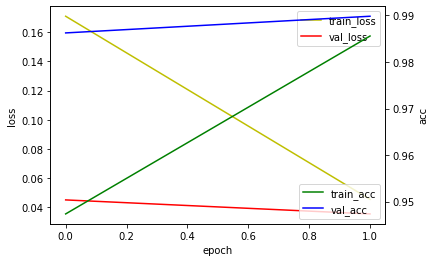

In [ ]:
fig, ax = plt.subplots()

# x축을 공통으로 사용하기 위해서, y는 왼쪽, 오른쪽 별도로 사용
# 왼쪽 : loss, 오른쪽 : acc
acc_ax = ax.twinx()

ax.plot( hist.history['loss'], 'y', label='train_loss')
ax.plot( hist.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(hist.history['accuracy'], 'g', label='train_acc')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_acc')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

ax.legend()
acc_ax.legend()

plt.show()

# 산출물/시스템통합 (웹)

- 모델 덤프
  - 학습된 모델을 파일로 저장하여 제공
  - 학습된 가중치, 편향값, 신경망의 구조

In [ ]:
# 저장 (신경망구조 + 가중치)
# 가중치나 모델을 저장할때 사용하는 확장자는 엔진별로 다르다
# 최근 MS에서 통합형 포멧을 제공
model.save('mnist_cnn.h5')

In [ ]:
# 불러오기
loadedModel = models.load_model('mnist_cnn.h5')

In [ ]:
# 테스트 데이터로 확인
loadedModel.evaluate( X_test, y_test )

313/313 [==============================] - 1s 3ms/step - loss: 0.0290 - accuracy: 0.9900


[0.029017992317676544, 0.9900000095367432]

In [ ]:
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000, 10))

In [ ]:
# 실제 이미지 파일을 이용하여 예측 수행
# /content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/test.pgm

- pgm 파일을 읽어서 예측
  - 파일 오픈 및 읽기
  - 전처리
  - 정규화
  - 엔진형태에 맞게 포멧 변환
  - 예측



```
P2 28 28 255 <= 매직코드, pgm 시그니처 코드
---------------(아래 부분이 픽셀 정보)
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ....
```



In [ ]:
# 1. 파일오픈및 데이터 로드
filePath = '/content/drive/MyDrive/고려대_AI개발을위한머신러닝딥러닝활용과정/학생용/test.pgm'
with open(filePath, 'r', encoding='utf-8') as fp:
  datas = fp.readlines()

datas

['P2 28 28 255\n',
 '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 84 185 159 151 60 36 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 222 254 254 254 254 241 198 198 198 198 198 198 198 198 170 52 0 0 0 0 0 0 0 0 0 0 0 0 67 114 72 114 163 227 254 225 254 254 254 250 229 254 254 140 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17 66 14 67 67 67 59 21 236 254 106 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 83 253 209 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 22 233 255 83 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 129 254 238 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 59 249 254 62 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
# 0:매짃코드, 1:픽셀 데이터
len(datas)

2

In [ ]:
# 실제 픽셀 데이터 구간 (784 -> 28x28)
datas[1]

'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 84 185 159 151 60 36 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 222 254 254 254 254 241 198 198 198 198 198 198 198 198 170 52 0 0 0 0 0 0 0 0 0 0 0 0 67 114 72 114 163 227 254 225 254 254 254 250 229 254 254 140 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 17 66 14 67 67 67 59 21 236 254 106 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 83 253 209 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 22 233 255 83 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 129 254 238 44 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 59 249 254 62 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 133 254 187 5 0 0 

In [ ]:
# 공백구분자 기반 분해
raws = datas[1].split()
len(raws)

784

In [ ]:
# 데이터는 배열 형태
nums = np.array( raws, dtype=np.float32 )/ 255.
nums

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# 원본데이터
# (784, ) -> NHWC, HWC
nums.shape

(784,)

In [ ]:
nums = nums.reshape( -1, PIXEL_H, PIXEL_W, 1 )
nums.shape

(1, 28, 28, 1)

In [ ]:
y_pred = loadedModel.predict( nums )
y_pred

array([[4.4417020e-10, 1.5466971e-09, 7.9157211e-08, 1.5773182e-08,
        2.0541024e-11, 1.1194454e-10, 1.1422060e-14, 9.9999964e-01,
        3.2188552e-10, 1.9720906e-07]], dtype=float32)

In [ ]:
# 예측값은 0 ~ 9까지 예측 결과를 확률로 제공 -> 가장 높은 값을 가진 확률 위치 찾아서(인덱스) -> 그 인덱스
# 에 해당하는 결과를 획득
# 가장 높은 값을 가진 인덱스,를 구하는 방법? -> np.argmax
y_pred.shape

(1, 10)

In [ ]:
# 인덱스 7번 -> 실제 몇번값인가?
np.argmax( y_pred )
# 여기서는 인덱스와 실제값이 동일 -> 예측 결과는 7

7

In [ ]:
# 0, 1, 2, 3, .... 9
# 0, 1, 2,

# 모델 정보 확인

In [ ]:
model.summary()
# shape의 변화 확인 가능
# 학습시 찾아야할 최적 파라미터 개수 : 3,274,634 => 가중치 개수
# 망의 구조(레이어 배치)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

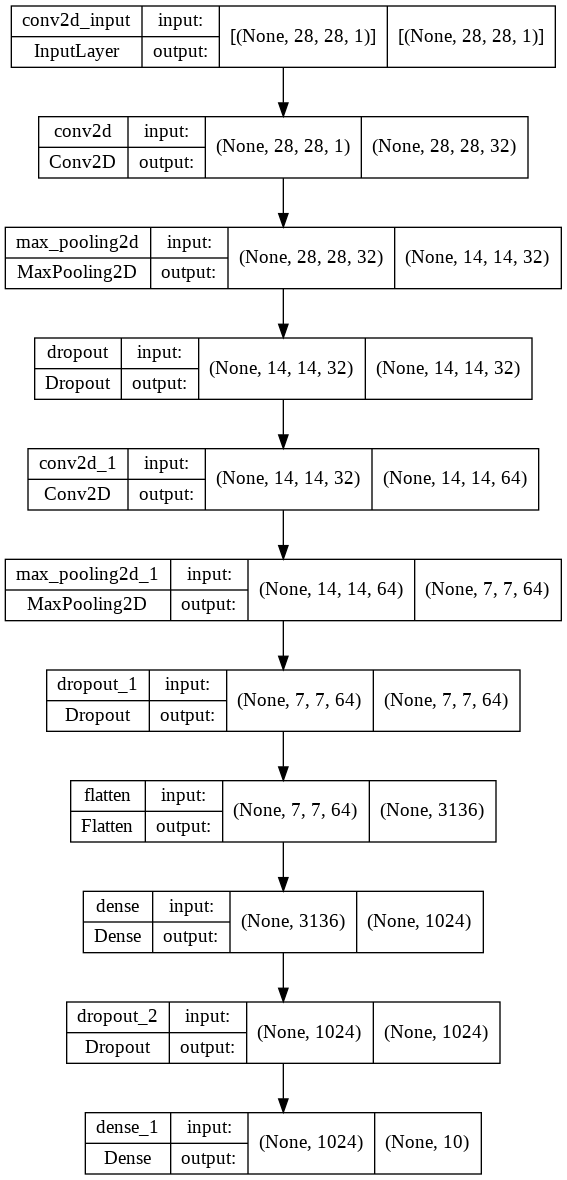

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png',
                          show_shapes=True, show_layer_names=True)

In [ ]:
model.save_weights('mnist_cnn.weight')